Starting this with a lookback of the teams that have won the whole thing 

In [234]:
import pandas as pd
import numpy as np
teamnamedf = pd.read_csv('MTeams.csv')

# Sample data creation for demonstration.
# Assuming the real CSV file is named 'basketball_games.csv' and contains the mentioned columns.
data = pd.read_csv('MNCAATourneyDetailedResults.csv')
# Creating a DataFrame from the sample data
df = pd.DataFrame(data)

# Filtering for seasons greater than 2010
filtered_df = df[df['Season'] > 2020]

# Finding the WTeamID with the maximum DayNum for each distinct Season
result_df = filtered_df.loc[filtered_df.groupby('Season')['DayNum'].idxmax(), ['Season', 'DayNum', 'WTeamID']]

result_df


,Season,DayNum,WTeamID
1180,2021,154,1124
1247,2022,154,1242
1314,2023,154,1163


In [235]:
conf_df = pd.read_csv('MconferenceTourneyGames.csv')
# conf_df =  conf_df[conf_df['ConfAbbrev'] == "big_east"]
conf_df_filtered = conf_df[conf_df['Season'] > 2003]


unique_confs = conf_df_filtered[['Season', 'ConfAbbrev']].drop_duplicates()

# For each unique season and conference pair, find the champion, runner-up, semifinalists, and quarterfinalists.
def tournament_details(row, df):
    season = row['Season']
    conf = row['ConfAbbrev']
    conf_games = df[(df['Season'] == season) & (df['ConfAbbrev'] == conf)]
    max_day = conf_games['DayNum'].max()
    champ_game = conf_games[conf_games['DayNum'] == max_day]
    champion = champ_game['WTeamID'].values[0]
    runner_up = champ_game['LTeamID'].values[0]
    semifinal_day = max_day - 1
    quarterfinal_day = max_day - 2
    semifinalists = conf_games[conf_games['DayNum'] == semifinal_day]['LTeamID'].tolist()
    quarterfinalists = conf_games[conf_games['DayNum'] == quarterfinal_day]['LTeamID'].tolist()
    return pd.Series([champion, runner_up, semifinalists, quarterfinalists])

# Apply the function to each unique conference-season pair
unique_confs[['Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']] = unique_confs.apply(lambda row: tournament_details(row, conf_df_filtered), axis=1)

# Merge this tournament detail with the main result DataFrame on Season
final_df_enhanced = pd.merge(result_df, unique_confs, on=['Season'], how='left')

final_df_enhanced


,Season,DayNum,WTeamID,ConfAbbrev,Champion,RunnerUp,Semifinalists,Quarterfinalists
0,2021,154,1124,a_sun,1251,1466,[],"[1391, 1195]"
1,2021,154,1124,a_ten,1382,1433,[],[]
2,2021,154,1124,aac,1222,1153,"[1455, 1272]","[1374, 1408, 1416, 1378]"
3,2021,154,1124,acc,1210,1199,[1314],"[1274, 1439, 1393]"
4,2021,154,1124,aec,1216,1262,[],[]
...,...,...,...,...,...,...,...,...
90,2023,154,1163,summit,1331,1295,"[1355, 1472]","[1377, 1442]"
91,2023,154,1163,sun_belt,1418,1375,"[1241, 1402]","[1407, 1379, 1267, 1204]"
92,2023,154,1163,swac,1411,1212,"[1238, 1105]","[1380, 1341]"
93,2023,154,1163,wac,1213,1381,"[1358, 1430]","[1370, 1465, 1469, 1470]"


In [236]:
tournament_results_df = unique_confs[['Season', 'ConfAbbrev', 'Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']].copy()

def determine_tournament_position_v2(row):
    season = row['Season']
    team_id = row['WTeamID']
    tournament_info = tournament_results_df[tournament_results_df['Season'] == season]

    # Initialize variables
    conf = None
    position = None

    # Check for champion, runner-up, semifinalist, quarterfinalist by iterating through the rows
    for _, t_row in tournament_info.iterrows():
        # Direct match for Champion and RunnerUp
        if team_id == t_row['Champion']:
            conf = t_row['ConfAbbrev']
            position = 'Champion'
            break
        elif team_id == t_row['RunnerUp']:
            conf = t_row['ConfAbbrev']
            position = 'RunnerUp'
            break
        # Check within lists for Semifinalists and Quarterfinalists
        elif any(team_id == semi_id for semi_id in t_row['Semifinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Semifinalist'
            break
        elif any(team_id == quarter_id for quarter_id in t_row['Quarterfinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Quarterfinalist'
            break

    return pd.Series([conf, position])

# Re-apply the corrected function to the results dataframe
result_df[['ConfAbbrev', 'TournamentResult']] = result_df.apply(determine_tournament_position_v2, axis=1)

result_df

,Season,DayNum,WTeamID,ConfAbbrev,TournamentResult
1180,2021,154,1124,big_twelve,Semifinalist
1247,2022,154,1242,big_twelve,Champion
1314,2023,154,1163,big_east,Semifinalist


In [237]:
df = final_df_enhanced

# Remove the 'WTeamID' and 'DayNum' columns
df.drop(columns=['WTeamID', 'DayNum'], inplace=True)

# Initialize a list to hold the new row-wise data
rows = []

# Iterate over each row in the dataframe to transform and accumulate the data
for _, row in df.iterrows():
    season, conf = row['Season'], row['ConfAbbrev']
    # Champion
    rows.append([season, conf, 'Champion', row['Champion']])
    # RunnerUp
    rows.append([season, conf, 'RunnerUp', row['RunnerUp']])
    # Semifinalists
    for team in row['Semifinalists']:
        rows.append([season, conf, 'Semifinalist', team])
    # Quarterfinalists
    for team in row['Quarterfinalists']:
        rows.append([season, conf, 'Quarterfinalist', team])

# Create a new DataFrame from the rows list
df_transformed = pd.DataFrame(rows, columns=['Season', 'ConfAbbrev', 'ConfTournamentPlace', 'TeamID'])

df_transformed.head(200)

,Season,ConfAbbrev,ConfTournamentPlace,TeamID
0,2021,a_sun,Champion,1251
1,2021,a_sun,RunnerUp,1466
2,2021,a_sun,Quarterfinalist,1391
3,2021,a_sun,Quarterfinalist,1195
4,2021,a_ten,Champion,1382
...,...,...,...,...
195,2022,a_ten,Quarterfinalist,1433
196,2022,a_ten,Quarterfinalist,1382
197,2022,aac,Champion,1222
198,2022,aac,RunnerUp,1272


In [238]:
data = pd.read_csv('MNCAATourneyDetailedResults.csv')
games_df = data

team_season_games = games_df.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins').rename(columns={'WTeamID': 'TeamID'})
team_season_losses = games_df.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses').rename(columns={'LTeamID': 'TeamID'})

# Merge the win and loss counts on Season and TeamID, filling missing values with 0
team_games_combined = pd.merge(team_season_games, team_season_losses, on=['Season', 'TeamID'], how='outer').fillna(0)

# Calculate total games played
team_games_combined['GamesPlayed'] = team_games_combined['Wins'] + team_games_combined['Losses']

# Drop the Wins and Losses columns as they are not required for the final output
team_games_combined.drop(columns=['Wins', 'Losses'], inplace=True)

team_games_combined

,Season,TeamID,GamesPlayed
0,2003,1112,4.0
1,2003,1113,2.0
2,2003,1120,3.0
3,2003,1139,3.0
4,2003,1141,2.0
...,...,...,...
1330,2023,1429,1.0
1331,2023,1433,1.0
1332,2023,1436,1.0
1333,2023,1438,1.0


In [239]:
conf_tourney_competitors_ncaa_tourney_results = pd.merge(df_transformed,team_games_combined, on=['Season', 'TeamID'], how='inner')
print(conf_tourney_competitors_ncaa_tourney_results )

     Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed
0      2021      a_sun            Champion    1251          1.0
1      2021      a_ten            Champion    1382          1.0
2      2021        aac            Champion    1222          5.0
3      2021        aac        Semifinalist    1455          1.0
4      2021        acc            Champion    1210          1.0
..      ...        ...                 ...     ...          ...
187    2023   sun_belt            Champion    1418          1.0
188    2023       swac            Champion    1411          1.0
189    2023        wac            Champion    1213          1.0
190    2023        wcc            Champion    1211          4.0
191    2023        wcc            RunnerUp    1388          2.0

[192 rows x 5 columns]


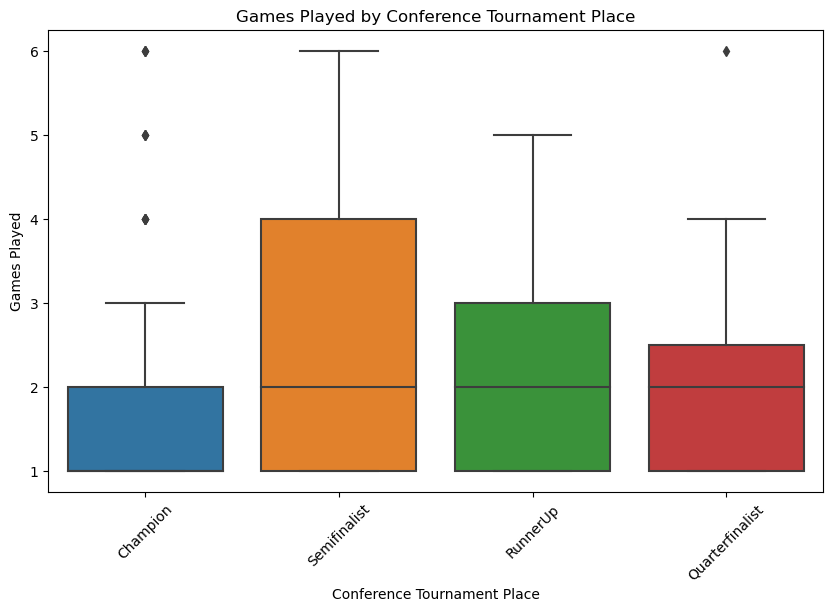

In [240]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=conf_tourney_competitors_ncaa_tourney_results, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

In [241]:
teamSeeds_df = pd.read_csv('MNCAATourneySeeds.csv')
teamSeeds_df['SeedNum'] = teamSeeds_df['Seed'].str.extract('(\d+)').astype(int)

# Filter the DataFrame for rows where the seed number is less than 8
teamSeeds_df = teamSeeds_df[teamSeeds_df['SeedNum'] < 17]

# Drop the temporary SeedNum column if no longer needed
# teamSeeds_df = filtered_df.drop(columns=['SeedNum'])

filtered_df
print(teamSeeds_df)



      Season Seed  TeamID  SeedNum
0       1985  W01    1207        1
1       1985  W02    1210        2
2       1985  W03    1228        3
3       1985  W04    1260        4
4       1985  W05    1374        5
...      ...  ...     ...      ...
2485    2023  Z12    1433       12
2486    2023  Z13    1233       13
2487    2023  Z14    1213       14
2488    2023  Z15    1421       15
2489    2023  Z16    1224       16

[2490 rows x 4 columns]


In [242]:
top8conftourneyResults = pd.merge(conf_tourney_competitors_ncaa_tourney_results,teamSeeds_df, on=['Season', 'TeamID'], how='inner')
print(top8conftourneyResults)

     Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed  Seed  SeedNum
0      2021      a_sun            Champion    1251          1.0   Y13       13
1      2021      a_ten            Champion    1382          1.0   W09        9
2      2021        aac            Champion    1222          5.0   Y02        2
3      2021        aac        Semifinalist    1455          1.0  X11b       11
4      2021        acc            Champion    1210          1.0   Y09        9
..      ...        ...                 ...     ...          ...   ...      ...
187    2023   sun_belt            Champion    1418          1.0   W13       13
188    2023       swac            Champion    1411          1.0  W16b       16
189    2023        wac            Champion    1213          1.0   Z14       14
190    2023        wcc            Champion    1211          4.0   Z03        3
191    2023        wcc            RunnerUp    1388          2.0   Z05        5

[192 rows x 7 columns]


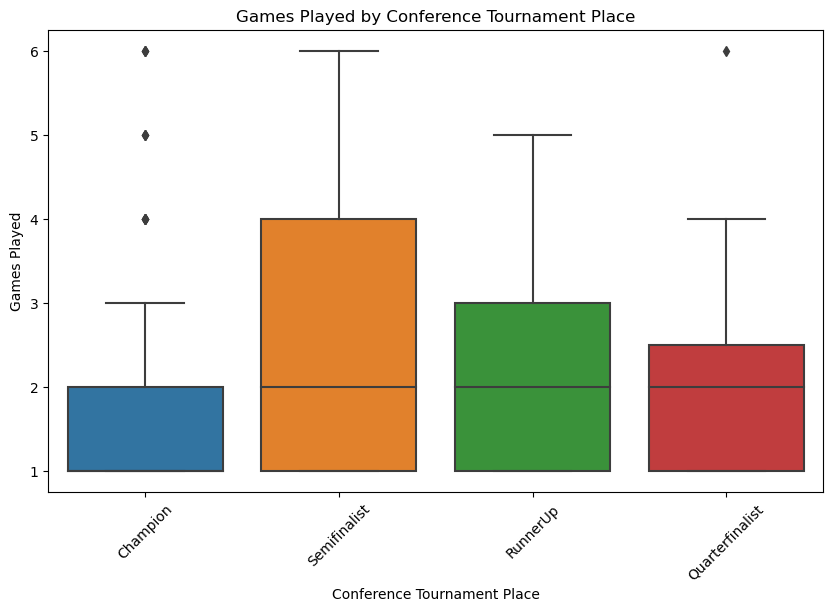

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

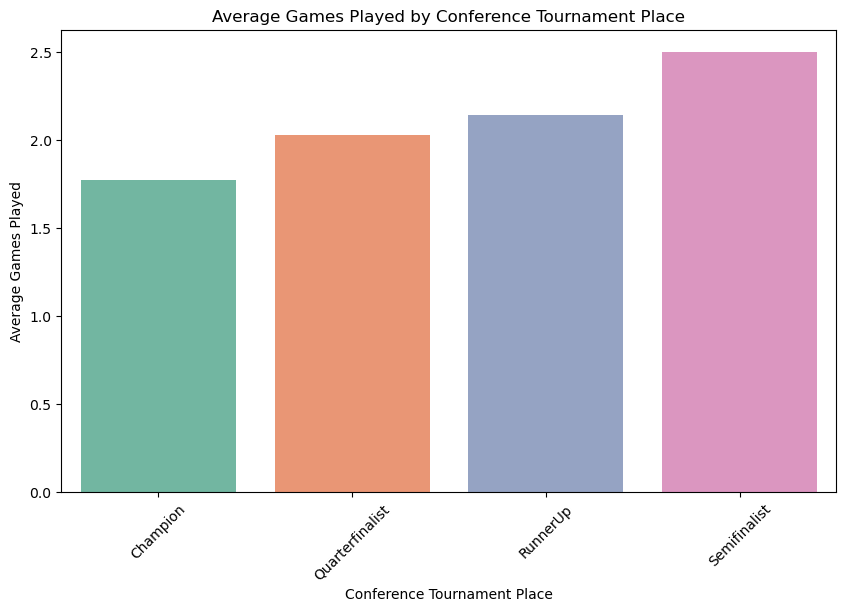

In [244]:
avg_games_played = top8conftourneyResults.groupby('ConfTournamentPlace')['GamesPlayed'].mean().reset_index()

# Plotting the average games played
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_games_played, x='ConfTournamentPlace', y='GamesPlayed', palette="Set2")
plt.title('Average Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.xticks(rotation=45)
plt.show()

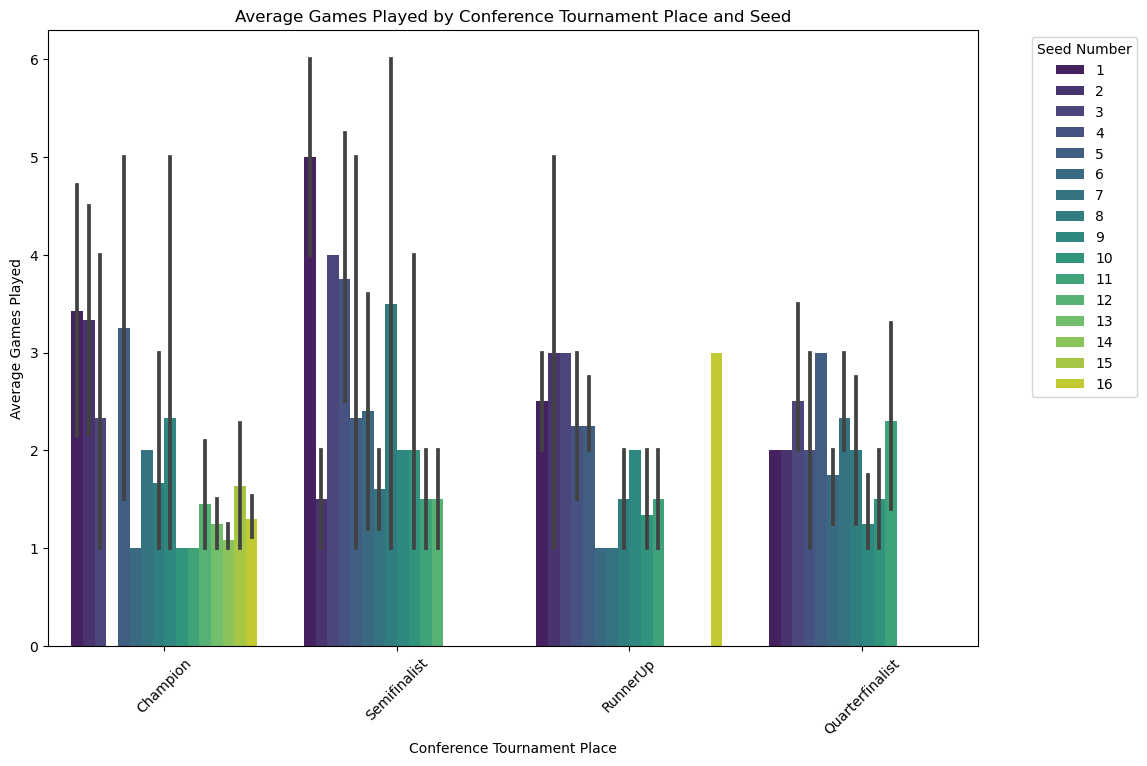

In [245]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed', hue='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


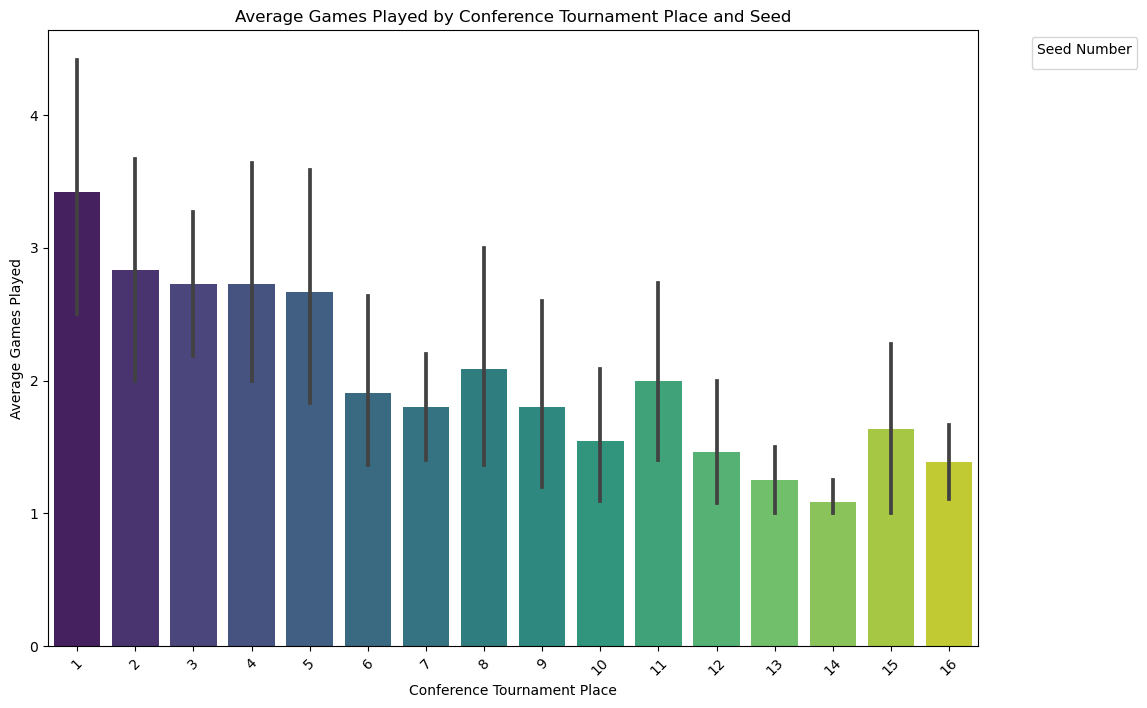

In [246]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults,  y='GamesPlayed', x='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [247]:
import plotly.graph_objects as go
import numpy as np
df = top8conftourneyResults
df = df[df['ConfTournamentPlace']!="Quarterfinalist"]

# Assuming 'df' is your DataFrame with detailed game records, including SeedNum
# Calculate the average games played for each SeedNum
avg_games_played_by_seed = df.groupby('SeedNum').agg(
    GamesPlayed=pd.NamedAgg(column='GamesPlayed', aggfunc='mean'),
    Count=pd.NamedAgg(column='GamesPlayed', aggfunc='count')  # Counting records per SeedNum
).reset_index()


# Sort the DataFrame by SeedNum to ensure the order is correct
avg_games_played_by_seed = avg_games_played_by_seed.sort_values(by='SeedNum')

# Calculate the deltas for the waterfall chart
# For the waterfall chart, the first delta is the average games played by the 1 seed
# Subsequent deltas are the changes from one seed to the next
deltas = np.diff(avg_games_played_by_seed['GamesPlayed'], prepend=avg_games_played_by_seed['GamesPlayed'].iloc[0])

# Adjust the measures array for the waterfall chart
measures = ['relative'] * len(deltas)
measures[0] = 'absolute'  # The first value is the starting point (absolute)

# Text for the annotations
text_values = [f"{delta:.2f}" if i != 0 else f"{avg_games_played_by_seed['GamesPlayed'].iloc[0]:.2f}" for i, delta in enumerate(deltas)]

# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Average Games Played",
    orientation="v",
    measure=measures,
    x=avg_games_played_by_seed['SeedNum'].astype(str).tolist(),
    textposition="outside",
    text=text_values,
    y=deltas,
    connector={"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title="Delta of Average Games Played by Seed Number <br>Team needed to finish 4th or better in conf tourney<br>Last 20 Years",
    xaxis_title="Seed Number",
    yaxis_title="Delta in Average Games Played",
    showlegend=True
)

fig.show()
print(avg_games_played_by_seed)

    SeedNum  GamesPlayed  Count
0         1     3.545455     11
1         2     2.909091     11
2         3     2.857143      7
3         4     3.000000      8
4         5     2.636364     11
5         6     2.000000      7
6         7     1.571429      7
7         8     2.142857      7
8         9     2.166667      6
9        10     1.571429      7
10       11     1.400000      5
11       12     1.461538     13
12       13     1.250000     12
13       14     1.083333     12
14       15     1.636364     11
15       16     1.388889     18


-- 2003-2024

#1s and #2s - not the same degree of elite 
#6,#7,#8,#11 - similar durations for tourney runs
#9,#10, #12 - not dead last, but pretty close
#16 is the better upset choice if the team is contending in their conference play

What do #1/2 seeds look like that lost in the first round

2021-2024
Totally different 


In [248]:
seeds = [1,2]
topseeds = top8conftourneyResults[top8conftourneyResults['SeedNum'].isin(seeds)]
topseedslosefirst = topseeds[topseeds['GamesPlayed']==1]
print(topseedslosefirst)

     Season  ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed Seed  SeedNum
17     2021     big_ten            RunnerUp    1326          1.0  Z02        2
114    2022         sec        Semifinalist    1246          1.0  W02        2
144    2023     big_ten            Champion    1345          1.0  W01        1
172    2023  pac_twelve            Champion    1112          1.0  X02        2


https://ncaaorg.s3.amazonaws.com/championships/sports/basketball/rules/men/2020-21PRMBB_RulesChanges.pdf

To amend Rule 2-11.6 by providing that the shot clock shall be reset to 20 seconds or the time remaining as set 
forth in subsections c. and d. of this rule when the offensive team retains or gains possession of the ball for a 
throw-in in the front court. Exception: When no reset is required per Rule 2-11.6.a or there is a change of team 
possession in the backcourt and the ball remains live. To accomplish this objective, the change would further 
require that Rule 2-11.6.b.8 only be applicable when the alternating possession arrow favors the defense. If the 
arrow favors the offense, there would be a 20-second reset under Rule 2-11.6.c. 
 
Rationale: The rule was changed initially last year to 1) increase the pace of play, 2) increase the number of 
possessions per team and 3) increase scoring. This amendment would correct an omission from last year’s rule 
and facilitate a clearer understanding of the rule for players, coaches and officials and further encourage the three 
objectives of this original rule.

In [249]:
import pandas as pd
df = pd.read_csv('MRegularSeasonDetailedResults.csv')
# Assuming df is your DataFrame

# Convert Season to integer if it's not already, to perform comparisons
df['Season'] = df['Season'].astype(int)

# Split the DataFrame into two based on the season
df_2000_2010 = df[(df['Season'] >= 2000) & (df['Season'] <= 2010)]
df_2010_2015 = df[(df['Season'] >= 2011) & (df['Season'] <= 2015)]
df_2015_2020 = df[(df['Season'] >= 2016) & (df['Season'] <= 2020)]

df_2021_2024 = df[(df['Season'] >= 2021) & (df['Season'] <= 2024)]

# Calculate the average scores for each period
avg_scores_2000_2010 = {
    'Average WScore (2000-2010)': df_2000_2010['WScore'].mean(),
    'Average LScore (2000-2010)': df_2000_2010['LScore'].mean()
}
avg_scores_2010_2015 = {
    'Average WScore (2010-2015)': df_2010_2015['WScore'].mean(),
    'Average LScore (2010-2015)': df_2010_2015['LScore'].mean()
}

avg_scores_2015_2020 = {
    'Average WScore (2015-2020)': df_2015_2020['WScore'].mean(),
    'Average LScore (2015-2020)': df_2015_2020['LScore'].mean()
}


avg_scores_2021_2024 = {
    'Average WScore (2021-2024)': df_2021_2024['WScore'].mean(),
    'Average LScore (2021-2024)': df_2021_2024['LScore'].mean()
}

# Output the results
avg_scores_2000_2010,avg_scores_2010_2015,avg_scores_2015_2020, avg_scores_2021_2024

({'Average WScore (2000-2010)': 74.80143376464906,
  'Average LScore (2000-2010)': 62.73630424282482},
 {'Average WScore (2010-2015)': 73.87725645374034,
  'Average LScore (2010-2015)': 62.05381571509327},
 {'Average WScore (2015-2020)': 78.02184718100891,
  'Average LScore (2015-2020)': 65.98030415430267},
 {'Average WScore (2021-2024)': 76.95354227021333,
  'Average LScore (2021-2024)': 65.01632868053727})

In [250]:
# Convert Season to integer if it's not already, for consistency
df['Season'] = df['Season'].astype(int)

# Group by the 'Season' and calculate the mean for 'WScore' and 'LScore'
seasonal_averages = df.groupby('Season')[['WScore', 'LScore']].mean()

# Reset index to make 'Season' a column again for easier access
seasonal_averages.reset_index(inplace=True)

# Print out the results
print("Average WScore and LScore by Season:")
print(seasonal_averages)

Average WScore and LScore by Season:
    Season     WScore     LScore
0     2003  75.795061  63.756932
1     2004  74.971122  62.990155
2     2005  74.693690  62.635294
3     2006  74.587555  62.666597
4     2007  74.829467  62.761650
5     2008  74.962425  62.755375
6     2009  74.033721  61.980377
7     2010  74.652480  62.484325
8     2011  74.374190  62.470644
9     2012  73.379973  61.415953
10    2013  72.840789  60.908083
11    2014  76.101268  64.452070
12    2015  72.680799  61.007845
13    2016  78.295958  66.327063
14    2017  78.645783  66.615199
15    2018  79.080296  66.919149
16    2019  77.887424  65.790591
17    2020  76.177928  64.230105
18    2021  76.808301  64.807004
19    2022  75.920112  64.170627
20    2023  76.618886  64.871831
21    2024  78.856084  66.483385


In [251]:

df = pd.read_csv('MRegularSeasonDetailedResults.csv')
df['Season'] = df['Season'].astype(int)
# Add a new column for the total score of each game
df['ScoreAvg'] = (df['WScore'] + df['LScore'])/2
df['3paAvg'] = (df['WFGA3'] + df['LFGA3'])/2
df['3pmAvg'] = (df['WFGM3'] + df['LFGM3'])/2
df['FTAAvg'] = (df['WFTA'] + df['LFTA'])/2
df['BlkAvg'] = (df['WBlk'] + df['LBlk'])/2
df['PFAvg'] = (df['WPF'] + df['LPF'])/2
df['TOAvg'] = (df['WTO'] + df['LTO'])/2







# Calculate the overall game average score


# Now calculate the average WScore and LScore for each season
seasonal_averages = df.groupby('Season')[['ScoreAvg','3paAvg','3pmAvg','FTAAvg','BlkAvg','PFAvg','TOAvg']].mean().reset_index()

seasonal_averages

,Season,ScoreAvg,3paAvg,3pmAvg,FTAAvg,BlkAvg,PFAvg,TOAvg
0,2003,69.775997,18.049068,6.259857,20.652730,3.262240,19.146880,14.907387
1,2004,68.980639,18.197769,6.267338,20.672063,3.190221,19.060271,14.852439
2,2005,68.664492,18.300321,6.337112,20.277326,3.268128,18.644171,14.698930
3,2006,68.627076,18.351902,6.395207,20.023649,3.272651,18.466470,14.707063
4,2007,68.795558,18.796054,6.551160,20.172120,3.247967,18.714654,14.564446
5,2008,68.858900,19.004455,6.663858,20.071567,3.306992,18.626574,14.446930
6,2009,68.007049,18.265384,6.254525,20.112974,3.250619,18.436083,13.960373
7,2010,68.568402,18.069637,6.172810,20.934733,3.438818,18.678320,13.774463
8,2011,68.422417,18.113610,6.234941,20.846931,3.395825,18.831395,13.518014
9,2012,67.397963,18.019227,6.186179,19.935180,3.376356,18.157719,13.493147


In [252]:
seasonal_averages = seasonal_averages.style.bar(subset=['3paAvg','TOAvg','FTAAvg','ScoreAvg','PFAvg'], color='#d65f5f')
seasonal_averages

,Season,ScoreAvg,3paAvg,3pmAvg,FTAAvg,BlkAvg,PFAvg,TOAvg
0,2003,69.775997,18.049068,6.259857,20.652730,3.262240,19.146880,14.907387
1,2004,68.980639,18.197769,6.267338,20.672063,3.190221,19.060271,14.852439
2,2005,68.664492,18.300321,6.337112,20.277326,3.268128,18.644171,14.698930
3,2006,68.627076,18.351902,6.395207,20.023649,3.272651,18.466470,14.707063
4,2007,68.795558,18.796054,6.551160,20.172120,3.247967,18.714654,14.564446
5,2008,68.858900,19.004455,6.663858,20.071567,3.306992,18.626574,14.446930
6,2009,68.007049,18.265384,6.254525,20.112974,3.250619,18.436083,13.960373
7,2010,68.568402,18.069637,6.172810,20.934733,3.438818,18.678320,13.774463
8,2011,68.422417,18.113610,6.234941,20.846931,3.395825,18.831395,13.518014
9,2012,67.397963,18.019227,6.186179,19.935180,3.376356,18.157719,13.493147


In [253]:
# Two 3pt line changes - initally it drops attempts and makes, but after several years attempts and makes regress back to initial amounts
# For 2023 charge rule - More free throws, more blocks, also less turnovers (https://kenpom.substack.com/p/the-charge-is-dead-and-the-game-is#:~:text=But%20non%2Dsteal%20turnovers%20are,steal%20can%27t%20be%20awarded.

# Going to proceed with only using 2020-2025 except for 2021 (issue with foul data)

# 2005-2006	
# Kicked balls will no longer reset the shot clock. If the violation occurs with less than 15 seconds, the clock will be reset to 15 seconds.
# 2006-2007	
# A timeout will not be recognized by an airborne player falling out of bounds.
# 2008-2009	Three point arc extended to 20' 9"
# 2008-2009	Eliminated first space nearest basket in the lane in the free throw shooting alignment (i.e. now only six players could stand next to the lane during a free throw instead of eight).
# 2008-2009	Referees may use instant replay to determine if a flagrant foul has been committed and who started the incident.
# 2015-2016	Shot clock changed to 30 seconds.
# 2015-2016	Dunks are permitted during warm ups
# 2019-2020	Three point arc extended to 22' 1 3/4"
# 2021-2022	Players are warned about flopping and accessed a technical for second warning.
# 2022-2023	Players are issued technical for flopping with no warning.

# --http://www.orangehoops.org/NCAA/NCAA%20Rule%20Changes.htm
    
    
    
    
    
#     2-11.6.b and 2
# 11.6.c 
# (Shot clock reset) 
# To establish that anytime the ball hits the rim (a pass, deflection or a shot) and the offense retains 
# possession in its frontcourt, the shot clock will reset to 20 seconds. Anytime the ball hits the rim and 
# the offense retains possession in its backcourt, the shot clock will reset to 30 seconds.   
 
# Rationale: This change makes it easier for officials on the floor because they will no longer need to 
# determine if the action is a legal try for goal or a pass (e.g., alley-oop plays).  
# 4-17.4.d 
# (Legal guarding 
# position) 
# To establish legal guarding position on an airborne player with the ball, the defender must establish 
# legal guarding position before the opponent places the last foot on the floor (i.e., plant foot) prior to 
# becoming airborne.  
 
# Rationale: The goal of this rules change is to reduce the number of charges and collisions that occur
    

In [254]:
# Convert Season to integer if it's not already, for consistency
df['Season'] = df['Season'].astype(int)

# Group by the 'Season' and calculate the mean for 'WScore' and 'LScore'
seasonal_averages = df.groupby('Season')[['WFGM3', 'LFGM3','WFGA3', 'LFGA3','WFTA', 'LFTA','WBlk', 'LBlk','WPF', 'LPF','WOR','LOR','NumOT','WTO','LTO','WStl','LStl']].mean()

# Reset index to make 'Season' a column again for easier access
seasonal_averages.reset_index(inplace=True)

# Print out the results
print("Average WScore and LScore by Season:")
print(seasonal_averages)

Average WScore and LScore by Season:
    Season     WFGM3     LFGM3      WFGA3      LFGA3       WFTA       LFTA  \
0     2003  6.695624  5.824090  17.377166  18.720971  23.250217  18.055243   
1     2004  6.708160  5.826515  17.570335  18.825202  23.286371  18.057755   
2     2005  6.769840  5.904385  17.678503  18.922139  22.787594  17.767059   
3     2006  6.845281  5.945133  17.821526  18.882279  22.458272  17.589027   
4     2007  7.043228  6.059092  18.138608  19.453500  22.698989  17.645251   
5     2008  7.162309  6.165408  18.386791  19.622119  22.575828  17.567306   
6     2009  6.749095  5.759954  17.743189  18.787579  22.485616  17.740331   
7     2010  6.655330  5.690291  17.520616  18.618659  23.306289  18.563177   
8     2011  6.733321  5.736561  17.675562  18.551658  23.221883  18.471979   
9     2012  6.744146  5.628212  17.602513  18.435941  22.369503  17.500857   
10    2013  6.644925  5.603571  17.671992  18.446241  21.878759  17.493985   
11    2014  6.729019  5.770

Trying to recreate kenpom metrics for this

In [255]:
import pandas as pd

# Assuming 'df' is your DataFrame after reading from the CSV
df = pd.read_csv('MRegularSeasonDetailedResults.csv')

# Calculate margins
df['WMargin'] = df['WScore'] - df['LScore']  # Victory margin for winning team
df['LMargin'] = df['LScore'] - df['WScore']  # Loss margin for losing team

# Calculate Adjusted Tempo (AdjT) for both winning and losing teams in each game
df['WPoss'] = df['WFGA'] - df['WOR'] + df['WTO'] + 0.475 * df['WFTA']
df['LPoss'] = df['LFGA'] - df['LOR'] + df['LTO'] + 0.475 * df['LFTA']
df['WTurnoverRate'] = df['WTO'] / df['WPoss']
df['LTurnoverRate'] = df['LTO'] / df['LPoss']

# Calculate eFG% for winning and losing teams
df['WeFG%'] = (df['WFGM'] + 0.5 * df['WFGM3']) / df['WFGA']
df['LeFG%'] = (df['LFGM'] + 0.5 * df['LFGM3']) / df['LFGA']

# Calculate Offensive Rebounding Percentage (OR%) for winning and losing teams
df['WOR%'] = df['WOR'] / (df['WOR'] + df['LDR'])
df['LOR%'] = df['LOR'] / (df['LOR'] + df['WDR'])

# Calculate True Shooting Percentage (TS%) for winning and losing teams
df['WTS%'] = df['WScore'] / (2 * (df['WFGA'] + 0.475 * df['WFTA']))
df['LTS%'] = df['LScore'] / (2 * (df['LFGA'] + 0.475 * df['LFTA']))

# Calculate Assist Rate for winning and losing teams
df['WAssistRate'] = df['WAst'] / df['WFGM']
df['LAssistRate'] = df['LAst'] / df['LFGM']
# Prepare DataFrames for winning and losing scenarios with all metrics including margins
winning_df = df[['Season', 'WTeamID', 'WPoss', 'WTurnoverRate', 'WeFG%', 'WOR%', 'WTS%', 'WAssistRate', 'WMargin']].rename(columns={'WTeamID': 'TeamID', 'WPoss': 'Poss', 'WTurnoverRate': 'TurnoverRate', 'WeFG%': 'eFG%', 'WOR%': 'OR%', 'WTS%': 'TS%', 'WAssistRate': 'AssistRate', 'WMargin': 'AvgVictoryMargin'})
losing_df = df[['Season', 'LTeamID', 'LPoss', 'LTurnoverRate', 'LeFG%', 'LOR%', 'LTS%', 'LAssistRate', 'LMargin']].rename(columns={'LTeamID': 'TeamID', 'LPoss': 'Poss', 'LTurnoverRate': 'TurnoverRate', 'LeFG%': 'eFG%', 'LOR%': 'OR%', 'LTS%': 'TS%', 'LAssistRate': 'AssistRate', 'LMargin': 'AvgLossMargin'})

# Concatenate winning and losing DataFrames to have a unified view
all_games_df = pd.concat([winning_df, losing_df])
# print(all_games_df[all_games_df['TeamID']==1104])
# Group by TeamID and Season to calculate the metrics including average victory and loss margins
team_metrics = all_games_df.groupby(['Season', 'TeamID']).agg({
    'Poss': 'mean',  # Mean Adjusted Tempo
    'TurnoverRate': 'mean',  # Mean Turnover Rate
    'eFG%': 'mean',  # Mean Effective Field Goal Percentage
    'OR%': 'mean',  # Mean Offensive Rebounding Percentage
    'TS%': 'mean',  # Mean True Shooting Percentage
    'AssistRate': 'mean',  # Mean Assist Rate
    'AvgVictoryMargin': 'mean',  # Mean Victory Margin
    'AvgLossMargin': 'mean'  # Mean Loss Margin
}).reset_index()

# Note: AvgVictoryMargin and AvgLossMargin will be NaN for teams that had no wins or losses, respectively. You might want to fill or handle NaN values as needed.
win_count = winning_df.groupby(['Season', 'TeamID']).size().reset_index(name='WinCount')

# Merge win count back into the team_metrics DataFrame
team_metrics = pd.merge(team_metrics, win_count, on=['Season', 'TeamID'], how='left')

# Fill NaN values in WinCount with 0 for teams that did not win any games
team_metrics['WinCount'] = team_metrics['WinCount'].fillna(0)
# The result is a DataFrame with each team's average metrics by season, including average victory and loss margins
print(team_metrics)


      Season  TeamID       Poss  TurnoverRate      eFG%       OR%       TS%  \
0       2003    1102  55.161607      0.205098  0.584407  0.168235  0.598476   
1       2003    1103  70.983333      0.179353  0.536564  0.305803  0.578084   
2       2003    1104  66.833929      0.199076  0.475785  0.371256  0.516009   
3       2003    1105  77.146154      0.240928  0.457983  0.335166  0.498929   
4       2003    1106  67.856250      0.250859  0.481697  0.349480  0.504722   
...      ...     ...        ...           ...       ...       ...       ...   
7612    2024    1474  75.556000      0.150505  0.498955  0.240829  0.532557   
7613    2024    1475  70.913636      0.195337  0.460960  0.268282  0.508588   
7614    2024    1476  70.870000      0.187853  0.469899  0.196552  0.495546   
7615    2024    1477  71.473864      0.162404  0.457419  0.213401  0.486899   
7616    2024    1478  69.461905      0.157946  0.507365  0.227207  0.538311   

      AssistRate  AvgVictoryMargin  AvgLossMargin  

In [256]:

teamnamedf = pd.read_csv('MTeams.csv')
print(teamnamedf.info())
team_adjt_names = pd.merge(team_metrics, teamnamedf, on='TeamID', how='inner').fillna(0)
print(team_adjt_names.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TeamID         378 non-null    int64 
 1   TeamName       378 non-null    object
 2   FirstD1Season  378 non-null    int64 
 3   LastD1Season   378 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 11.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            7617 non-null   int64  
 1   TeamID            7617 non-null   int64  
 2   Poss              7617 non-null   float64
 3   TurnoverRate      7617 non-null   float64
 4   eFG%              7617 non-null   float64
 5   OR%               7617 non-null   float64
 6   TS%               7617 non-null   float64
 7   AssistRate        7617 non-null   float64
 8   

In [257]:
# team_adjt_names = team_adjt_names[team_adjt_names['TeamName'] =='Arizona']
# team_adjt_names

In [258]:
# Define your percentile groups
df=team_adjt_names
percentile_bins = [0, 0.05, 0.10, 0.30, 1.00]
labels = [1, 2, 3, 4]

# Dynamically add percentile rank columns for specified metrics
metrics = ['Poss', 'TurnoverRate', 'eFG%', 'OR%', 'TS%', 'AssistRate','AvgVictoryMargin','AvgLossMargin']
for metric in metrics:
    # Calculate percentile ranks within each season
    df[f'{metric}_Percentile'] = df.groupby('Season')[metric].transform(lambda x: x.rank(pct=True))

    # Manually assign groups based on the calculated percentile ranks
    conditions = [
        (df[f'{metric}_Percentile'] <= 0.10),
        (df[f'{metric}_Percentile'] > 0.10 & (df[f'{metric}_Percentile'] <= 0.2),
        (df[f'{metric}_Percentile'] > 0.20) & (df[f'{metric}_Percentile'] <= 0.40),
        (df[f'{metric}_Percentile'] > 0.40)
    ]

    # Assign group labels based on the conditions
    df[f'{metric}_Group'] = np.select(conditions, labels)

# Optional: Drop the intermediate Percentile columns if they are not needed
df.drop(columns=[f'{metric}_Percentile' for metric in metrics], inplace=True)
# df =df[df['Season'] >2020].head()
print(df.head())
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 15 (51404069.py, line 18)

In [ ]:
tourney_data = pd.read_csv('MNCAATourneyDetailedResults.csv')
games_df = tourney_data

team_season_games = games_df.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins').rename(columns={'WTeamID': 'TeamID'})
team_season_losses = games_df.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses').rename(columns={'LTeamID': 'TeamID'})

# Merge the win and loss counts on Season and TeamID, filling missing values with 0
team_games_combined = pd.merge(team_season_games, team_season_losses, on=['Season', 'TeamID'], how='outer').fillna(0)

# Calculate total games played
team_games_combined['GamesPlayed'] = team_games_combined['Wins'] + team_games_combined['Losses']

# Drop the Wins and Losses columns as they are not required for the final output
team_games_combined.drop(columns=['Wins', 'Losses'], inplace=True)

team_games_combined

,Season,TeamID,GamesPlayed
0,2003,1112,4.0
1,2003,1113,2.0
2,2003,1120,3.0
3,2003,1139,3.0
4,2003,1141,2.0
...,...,...,...
1330,2023,1429,1.0
1331,2023,1433,1.0
1332,2023,1436,1.0
1333,2023,1438,1.0


In [ ]:
print(df.head())
print(team_games_combined.head())
df.info(verbose=True)
team_games_combined.info(verbose=True)

testData = pd.merge(df,team_games_combined, on=['Season', 'TeamID'], how='inner')
testData.info(verbose=True)
print(testData.head(100))

   Season  TeamID       Poss  TurnoverRate      eFG%       OR%       TS%  \
0    2003    1102  55.161607      0.205098  0.584407  0.168235  0.598476   
1    2004    1102  54.142857      0.199743  0.586787  0.247548  0.607937   
2    2005    1102  56.380172      0.177240  0.545641  0.268673  0.569754   
3    2006    1102  56.737500      0.190574  0.580564  0.261127  0.606272   
4    2007    1102  59.278333      0.169864  0.581268  0.242810  0.615069   

   AssistRate  AvgVictoryMargin  AvgLossMargin  WinCount   TeamName  \
0    0.665276         15.583333     -11.250000      12.0  Air Force   
1    0.660022         15.136364     -10.000000      22.0  Air Force   
2    0.638651         16.058824      -8.000000      17.0  Air Force   
3    0.647504         13.045455      -6.166667      22.0  Air Force   
4    0.656890         19.227273      -9.375000      22.0  Air Force   

   FirstD1Season  LastD1Season  Poss_Group  TurnoverRate_Group  eFG%_Group  \
0           1985          2024        

     Season ConfAbbrev ConfTournamentPlace  TeamID       Poss  TurnoverRate  \
0      2021      a_sun            Champion    1251  64.757292      0.148872   
1      2021      a_ten            Champion    1382  66.221250      0.156410   
2      2021        aac            Champion    1222  66.994231      0.151487   
3      2021        aac        Semifinalist    1455  71.278947      0.148313   
4      2021        acc            Champion    1210  70.395000      0.148502   
..      ...        ...                 ...     ...        ...           ...   
187    2023   sun_belt            Champion    1418  69.791667      0.167995   
188    2023       swac            Champion    1411  73.298438      0.190631   
189    2023        wac            Champion    1213  67.532031      0.167866   
190    2023        wcc            Champion    1211  72.553906      0.140183   
191    2023        wcc            RunnerUp    1388  64.718750      0.147583   

         eFG%       OR%       TS%  AssistRate  AvgV

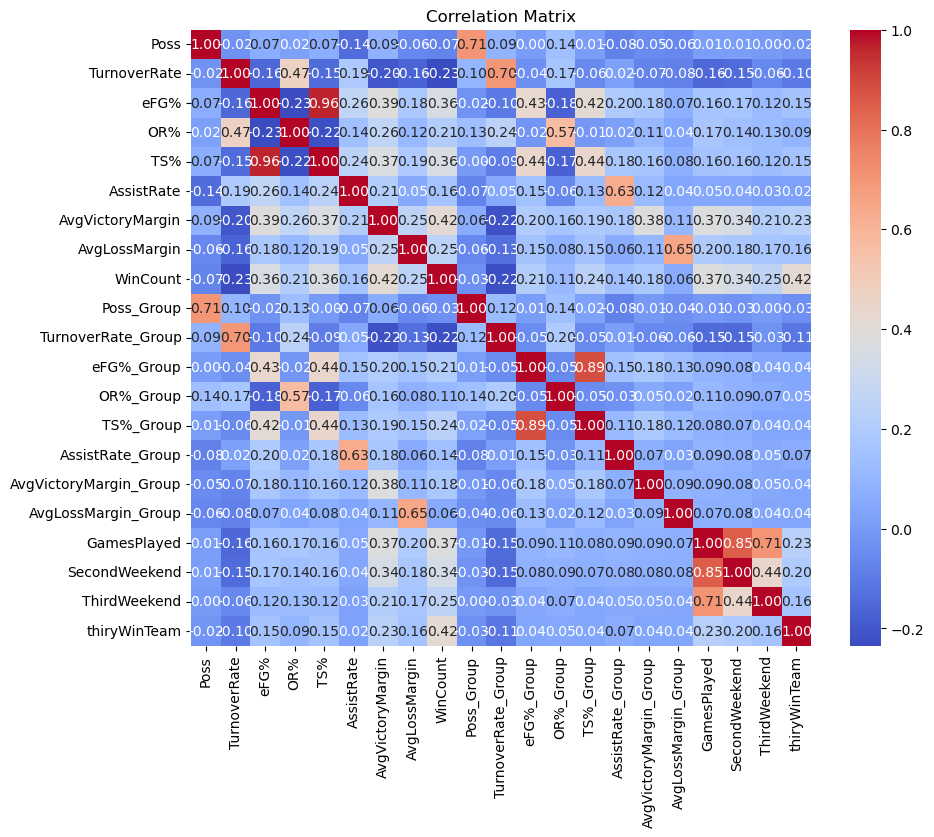

In [268]:
import pandas as pd

# Assuming df is your DataFrame with actual data
# df = pd.read_csv('your_data.csv') # Load your data

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Assuming testData is your DataFrame
# Select only the numeric columns for correlation analysis
numeric_data = testData.select_dtypes(include=[np.number])
numeric_data_all = numeric_data
numeric_data_all= pd.merge(df_transformed,numeric_data_all, on=['Season', 'TeamID'], how='inner')
numeric_data_all['conf_tournament_place'] = numeric_data_all['ConfAbbrev'].astype('category').cat.codes
numeric_data_all['conference'] = numeric_data_all['ConfTournamentPlace'].astype('category').cat.codes
print(numeric_data_all)
# df['Category_encoded'] = 
# numeric_data_all['Season'] = pd.to_numeric(numeric_data_all['Season'], errors='coerce')
numeric_data_all=numeric_data_all[numeric_data_all['Season'] > 2020]
print(numeric_data_all.dtypes)
df['conf_tournament_place'] = df['conf_tournament_place'].astype(int)
df['conference'] = df['conference'].astype(int)
numeric_data_all = numeric_data.drop(columns=['Season', 'TeamID','FirstD1Season','LastD1Season'])


numeric_data_all['SecondWeekend'] = np.where(numeric_data_all['GamesPlayed'] > 2, 1, 0)
numeric_data_all['ThirdWeekend'] = np.where(numeric_data_all['GamesPlayed'] > 4, 1, 0)
numeric_data_all['thiryWinTeam'] = np.where(numeric_data_all['WinCount'] >= 30, 1, 0)


print(numeric_data_all.dtypes)

# Calculate the correlation matrix for numeric columns only
corr_matrix = numeric_data_all.corr()

plt.figure(figsize=(10, 8))  # You can adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()
